In [27]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import binned_statistic_2d
import itertools
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmcrameri.cm as cmcr

from matplotlib.colors import LogNorm

plt.style.use('plotstyling.mplstyle')

In [2]:
db_filename = "../../DataStorage/AWS/Arctic/combined.nc"
aws_db = xr.open_dataset(db_filename)


In [4]:
channel_pairs = [
    (36, 41),
    (35, 42),
    (34, 43),
    (33, 44),
]

channels = [21, 31, 32, 33, 34, 35, 36, 41, 42, 43, 44]
channel_pairs_all = list(itertools.combinations(channels, 2))

adjacent_pairs = [(channels[i], channels[i+1]) for i in range(len(channels)-1)]

def reorder_pair(pair):
    # ordered so that we geta positive dTa in clear-sky.
    a, b = pair
    if 30 <= a < 40 and 30 <= b < 40:      # both in group 3
        return tuple(sorted((a, b), reverse=True))  # descending
    elif 40 <= a < 50 and 40 <= b < 50:    # both in group 4
        return tuple(sorted((a, b)))
    else:
        return (a, b)

adjacent_pairs = [reorder_pair(p) for p in adjacent_pairs]
pairs_of_pairs = list(itertools.combinations(adjacent_pairs, 2))

levels = [
    10 ** (-9),
    10 ** (-8),
    10 ** (-7),
    10 ** (-6),
    10 ** (-5),
    10 ** (-4),
    10 ** (-3),
    10 ** (-2),
    10 ** (-1),
]

NEDeltaT = {      # OG values
    21: 0.20,
     31: 0.36,
     32: 0.49,
     33: 0.55,
     34: 0.77,
     35: 0.82,
     36: 0.97,
     41: 1.53,
     42: 1.46,
     43: 1.01,
     44: 0.87,
    }

Ta_bins = np.linspace(80, 300, 111)
Ta_bin_centres = (Ta_bins[:-1] + Ta_bins[1:]) / 2
Ta_X, Ta_Y = np.meshgrid(Ta_bin_centres, Ta_bin_centres)

Delta_Ta_bins = np.linspace(-50, 50, 101)
Delta_Ta_bin_centres = (Delta_Ta_bins[:-1] + Delta_Ta_bins[1:]) / 2
Delta_Ta_X, Delta_Ta_Y = np.meshgrid(Delta_Ta_bin_centres, Delta_Ta_bin_centres)

surface_type_dict = {
    0: "Ocean",
    1: "Sea ice",
    2: "Land",
    3: "Water",
    4: "Snow",
    5: "Glacier"
}

In [5]:
def add_noise(Ta, sigma):
    Ta_noisy = Ta + np.random.normal(0, sigma, len(Ta))
    return Ta_noisy

def calculate_DeltaTa_distribution(aws_db, pairs_of_pairs, filter_idxs=None, NEDeltaT=NEDeltaT):
    H_results = []
    
    for (pair_x, pair_y) in pairs_of_pairs:
        ch_x_1, ch_x_2 = pair_x
        ch_y_1, ch_y_2 = pair_y
    
        # Compute ΔTa for x-pair and y-pair
        if filter_idxs is None:
            x1 = aws_db[f'Ta_Allsky_AWS{ch_x_1}'].values
            x2 = aws_db[f'Ta_Allsky_AWS{ch_x_2}'].values
            y1 = aws_db[f'Ta_Allsky_AWS{ch_y_1}'].values
            y2 = aws_db[f'Ta_Allsky_AWS{ch_y_2}'].values
        else:
            x1 = aws_db[f'Ta_Allsky_AWS{ch_x_1}'].values[filter_idxs]
            x2 = aws_db[f'Ta_Allsky_AWS{ch_x_2}'].values[filter_idxs]
            y1 = aws_db[f'Ta_Allsky_AWS{ch_y_1}'].values[filter_idxs]
            y2 = aws_db[f'Ta_Allsky_AWS{ch_y_2}'].values[filter_idxs]
    
        # add noise to Tas
        x1_noisy = add_noise(x1, NEDeltaT[ch_x_1])
        x2_noisy = add_noise(x2, NEDeltaT[ch_x_2])
        y1_noisy = add_noise(y1, NEDeltaT[ch_y_1])
        y2_noisy = add_noise(y2, NEDeltaT[ch_y_2])
    
        x = x2_noisy - x1_noisy
        y = y2_noisy - y1_noisy
    
        # Compute 2D histogram
        H, x_edges, y_edges = np.histogram2d(
            x.flatten(), y.flatten(),
            bins=(Delta_Ta_bins, Delta_Ta_bins),
            density=True
        )
    
        H_results.append(H)

    return H_results
    

In [6]:

results_all = calculate_DeltaTa_distribution(
    aws_db=aws_db,
    pairs_of_pairs=pairs_of_pairs,
    NEDeltaT=NEDeltaT,
    filter_idxs=None,
)


/tmp/ipykernel_41049/599571048.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(
/tmp/ipykernel_41049/599571048.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(
/tmp/ipykernel_41049/599571048.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 7))


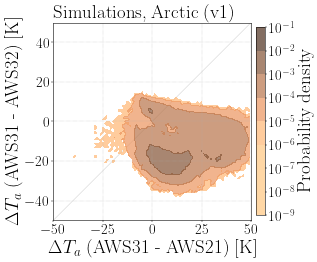

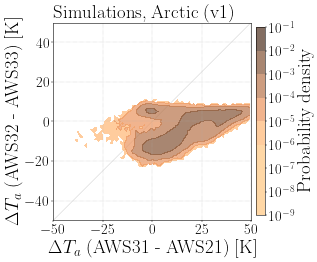

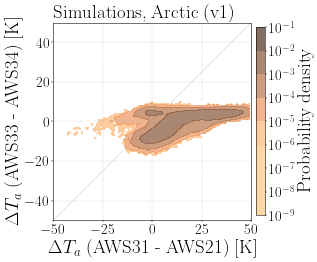

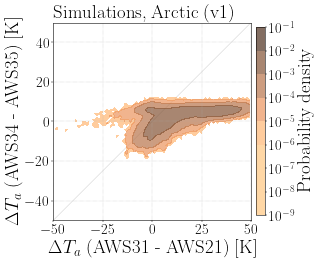

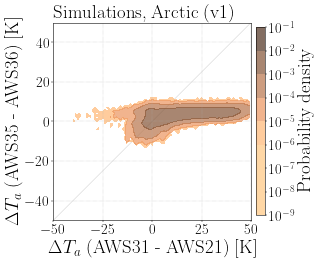

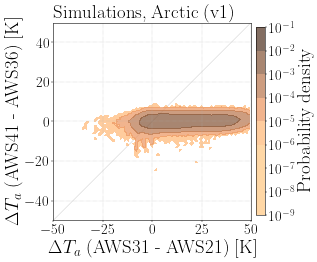

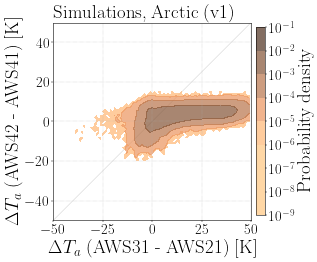

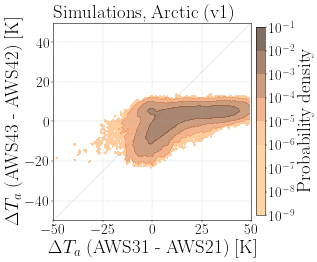

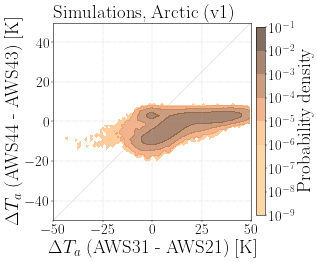

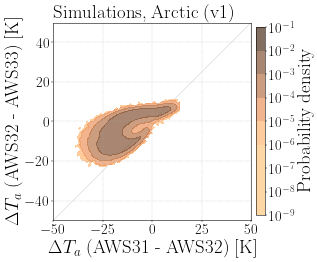

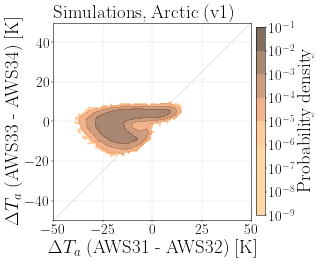

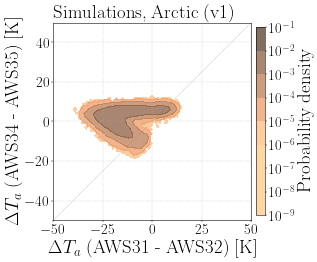

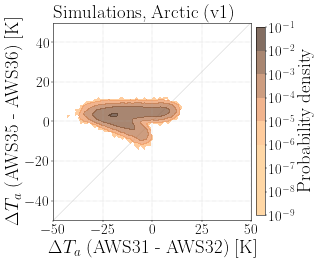

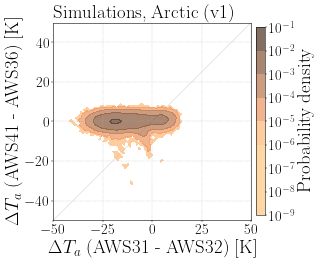

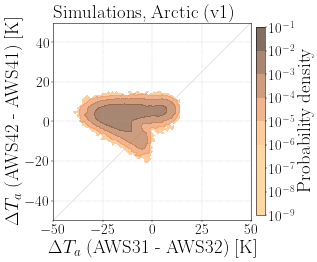

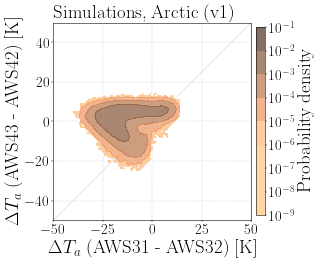

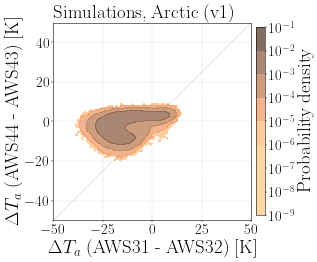

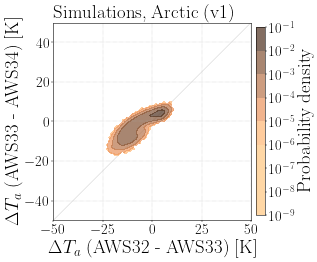

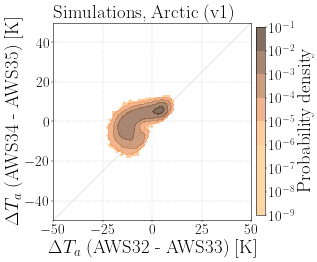

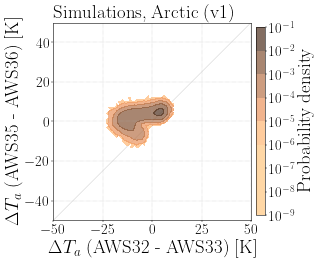

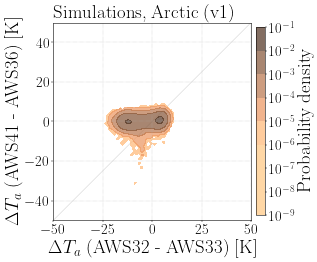

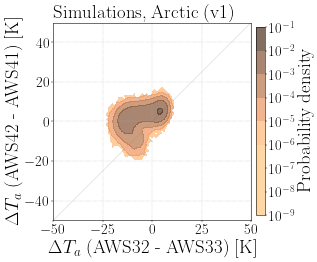

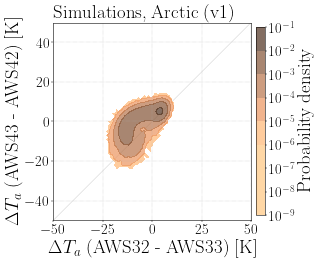

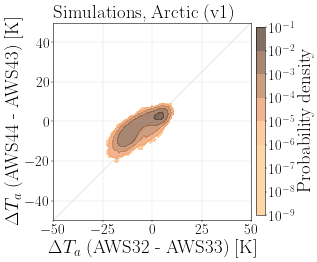

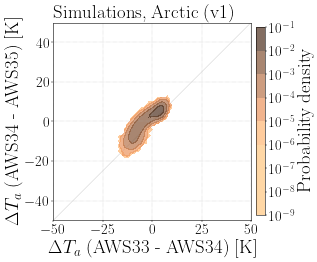

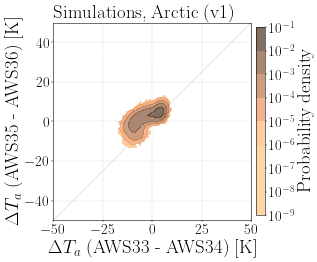

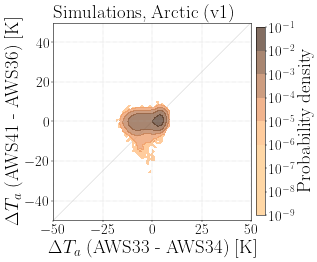

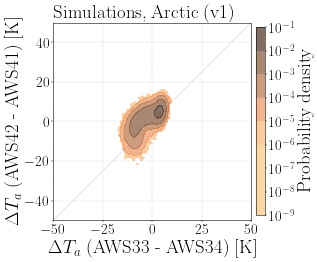

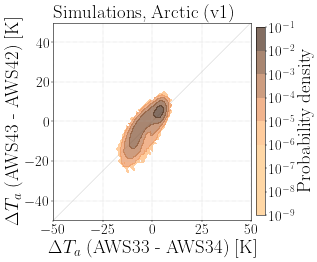

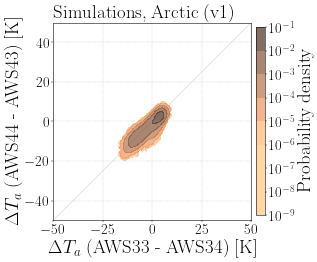

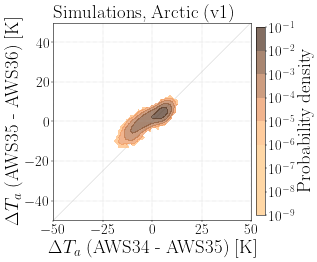

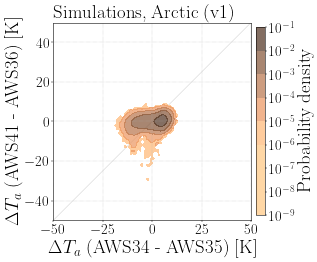

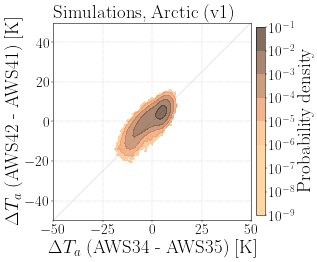

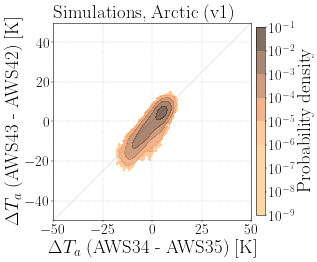

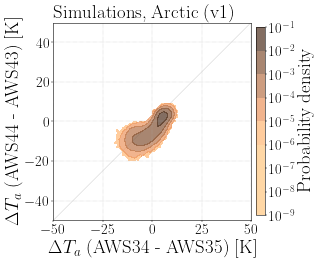

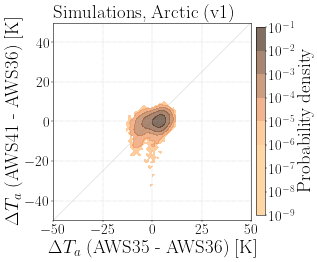

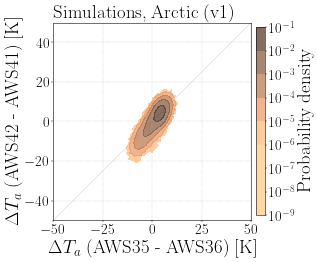

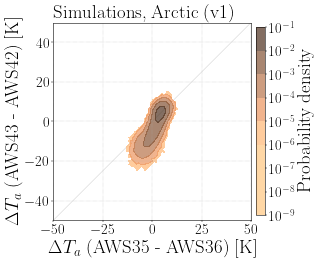

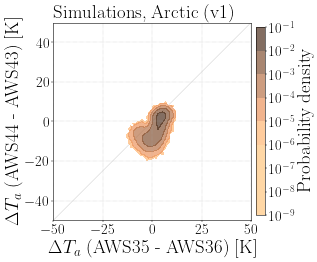

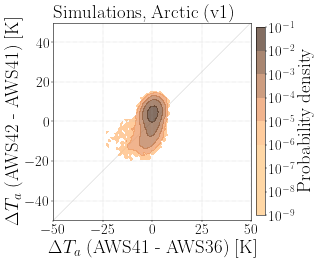

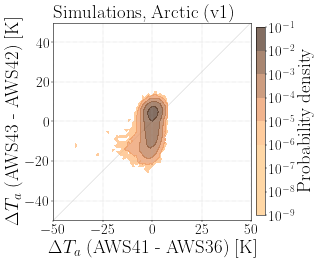

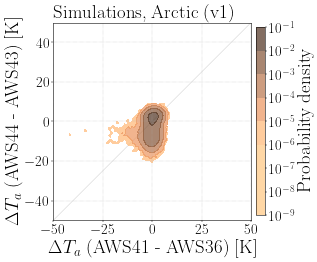

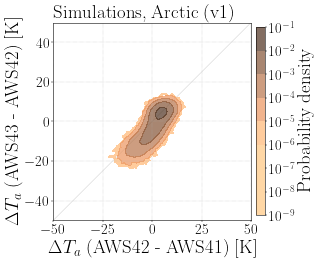

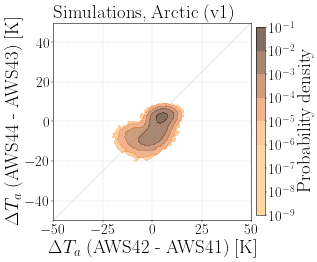

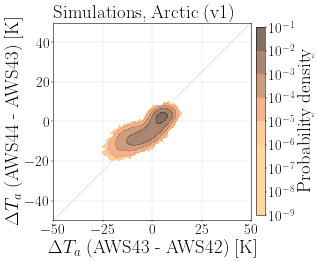

In [7]:
for idx, ((pair_x, pair_y), H) in enumerate(zip(pairs_of_pairs, results_all)):

    ch_x_1, ch_x_2 = pair_x
    ch_y_1, ch_y_2 = pair_y

    X, Y = np.meshgrid(Delta_Ta_bins[:-1], Delta_Ta_bins[:-1])

    H = results_all[idx]
    
    X, Y = np.meshgrid(Delta_Ta_bins[:-1], Delta_Ta_bins[:-1])
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    im = ax.contourf(
        X, Y, H.T,
        levels=levels,
        norm=LogNorm(vmin=1e-6, vmax=1),
        cmap="copper_r",
        alpha=0.7,
    )
    
    ax.plot([-50, 50], [-50, 50], color='lightgrey', lw=1, zorder=0)
    ax.grid(ls=':')
    
    
    ax.set_xlabel(rf'$\Delta T_a$ (AWS{ch_x_2} - AWS{ch_x_1}) [K]')
    ax.set_ylabel(rf'$\Delta T_a$ (AWS{ch_y_2} - AWS{ch_y_1}) [K]')
    ax.set_xlim([-50, 50])
    ax.set_ylim([-50, 50])
    ax.set_aspect('equal', adjustable='box')
    
    cbar = fig.colorbar(im, ax=ax, location='right', pad=0.02, shrink=0.85)
    cbar.set_label("Probability density")
    
    ax.set_title('Simulations, Arctic (v1)', loc="left")
    
    plt.tight_layout()
    
    plt.savefig(
            f"figures/dTa_neighbouring_channels/arctic/DeltaTa_{ch_x_1}_{ch_x_2}__{ch_y_1}_{ch_y_2}_arctic.png",
            facecolor="white",
            bbox_inches="tight",
            pad_inches=0.1,
            dpi=200,
        )




In [42]:
months = aws_db.CloudSat_Datetime.values.astype("datetime64[M]").astype(int) % 12 + 1
winter_idx = np.where(np.isin(months, [12, 1, 2]))[0]

aws34 = aws_db[f'Ta_Allsky_AWS34'].values
aws33 = aws_db[f'Ta_Allsky_AWS33'].values
aws43 = aws_db[f'Ta_Allsky_AWS43'].values
aws44 = aws_db[f'Ta_Allsky_AWS44'].values

group3_diff = aws33-aws34
group4_diff = aws44-aws43



# defining quadrants as starting top left, going clockwise

# quadrant 1: positive, both
quadrant1_idxs = np.where(
    ((group3_diff) > 0)
    & ((group4_diff) > 0)
)[0]

# quadrant 3: positive group 3, negative group 4
quadrant2_idxs = np.where(
    ((group3_diff) > 0)
    & ((group4_diff) < 0)
)[0]

# quadrant 3: negative, both
quadrant3_idxs = np.where(
    ((group3_diff) < 0)
    & ((group4_diff) < 0)
)[0]

# quadrant 4: positive group 4, negative group 3
quadrant4_idxs = np.where(
    ((group3_diff) < 0)
    & ((group4_diff) > 0)
)[0]

# quadrant 3 & above 1:1 (possible surface impact)
quadrant3_abovediagonal_idxs = np.where(
    ((group3_diff) < 0)
    & ((group4_diff) < 0)
    & (np.abs(group4_diff) < np.abs(group3_diff))
)[0]

quadrant3_belowdiagonal_idxs = np.where(
    ((group3_diff) < 0)
    & ((group4_diff) < 0)
    & (np.abs(group4_diff) > np.abs(group3_diff))
)[0]

quadrant_idx_list = [quadrant1_idxs, quadrant2_idxs, quadrant3_idxs, quadrant4_idxs]

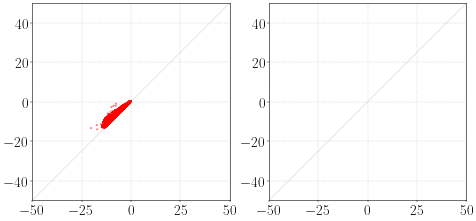

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].scatter(
        group3_diff[quadrant3_abovediagonal_idxs],
        group4_diff[quadrant3_abovediagonal_idxs],
        c="red",
        alpha=0.5,
        s=15,
        ec="None"
    )

for ax in axes:
    ax.plot([-50, 50], [-50, 50], color='lightgrey', lw=1, zorder=0)
    ax.grid(ls=':')
    
    ax.set_xlim([-50, 50])
    ax.set_ylim([-50, 50])
    ax.set_aspect('equal', adjustable='box')

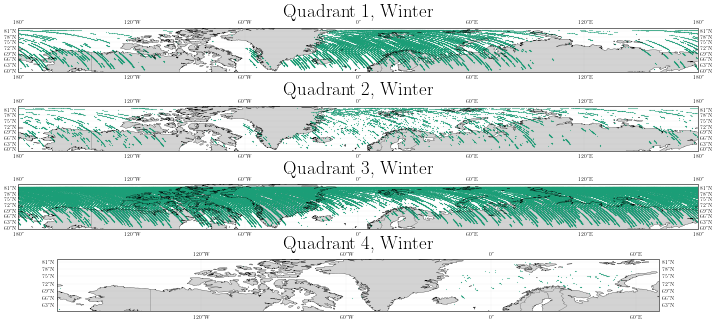

In [45]:
fig, axes = plt.subplots(4, 1,
    figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax in axes:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')

for i, quadrant_idx in enumerate(quadrant_idx_list):

    filter_idx = np.intersect1d(quadrant_idx, winter_idx, assume_unique=True)
    
    axes[i].scatter(
        aws_db["Longitude"].values[filter_idx],
        aws_db["Latitude"].values[filter_idx],
        color="C0",
        s=1,
        alpha=0.5,
        transform=ccrs.PlateCarree(),
    )
    axes[i].set_title(f"Quadrant {i+1}, Winter")

fig.tight_layout()


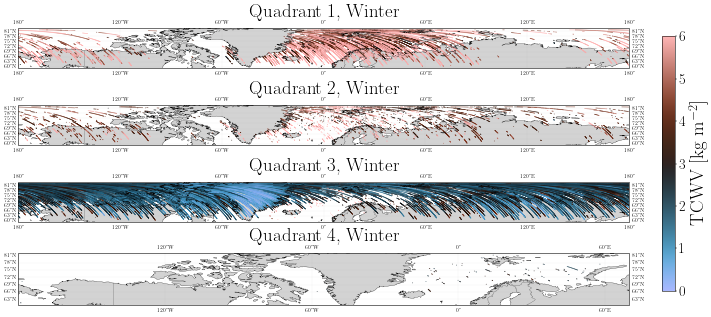

In [46]:
dry = aws_db.H2O_Column < 3

fig, axes = plt.subplots(
    4, 1,
    figsize=(20, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax in axes:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2,
                 color="gray", alpha=0.5, linestyle="--")

sc = None  # will store the last scatter

for i, quadrant_idx in enumerate(quadrant_idx_list):

    filter_idx = np.intersect1d(quadrant_idx, winter_idx, assume_unique=True)

    sc = axes[i].scatter(
        aws_db["Longitude"].values[filter_idx],
        aws_db["Latitude"].values[filter_idx],
        c=aws_db.H2O_Column[filter_idx],
        cmap=cmcr.berlin,
        vmin=0,
        vmax=6,
        s=2,
        alpha=0.9,
        transform=ccrs.PlateCarree(),
    )

    axes[i].set_title(f"Quadrant {i+1}, Winter")


fig.subplots_adjust(
    hspace=0.35,   # increase until titles stop overlapping
    right=0.92,    # leaves space for the colorbar (tweak with your x=0.93)
    top=0.95,      # a bit more headroom
    bottom=0.05
)

cbar = fig.colorbar(
    sc,
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.02,
)
cbar.set_label(r"TCWV [kg m$^{-2}$]")

# move colorbar slightly left (or right)
pos = cbar.ax.get_position()
cbar.ax.set_position([0.93, pos.y0, pos.width, pos.height])

plt.savefig(
        f"figures/dTa_neighbouring_channels/arctic/maps/dTa_quadrants_by_TCWV.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
)

In [47]:
aws_db.H2O_Column

<xarray.DataArray 'H2O_Column' (number: 636833)> Size: 5MB
array([2.723864, 2.561114, 2.387648, ..., 1.435175, 1.44651 , 1.462727])
Dimensions without coordinates: number
Attributes:
    units:      kg/m2
    long_name:  Water vapour path

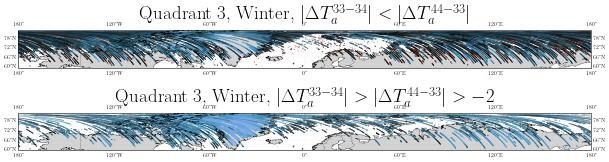

In [52]:
fig, axes = plt.subplots(2, 1,
    figsize=(18, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax in axes:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')

filter_idx = np.intersect1d(quadrant3_belowdiagonal_idxs, winter_idx, assume_unique=True)
    
axes[0].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[0].set_title(r"Quadrant 3, Winter, $|\Delta T_{a}^{33-34}| < |\Delta T_{a}^{44-33}|$")

filter_idx = np.intersect1d(quadrant3_abovediagonal_idxs, winter_idx, assume_unique=True)
    
axes[1].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[1].set_title(r"Quadrant 3, Winter, $|\Delta T_{a}^{33-34}| > |\Delta T_{a}^{44-33}| > -2$")

fig.subplots_adjust(
    hspace=0.35,
    right=0.92,
    top=0.95,
    bottom=0.05
)


plt.savefig(
        f"figures/dTa_neighbouring_channels/arctic/maps/dTa_quadrant_3_by_TCWV.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
)

# okay. but how do we know whats surface and what's cloud?
# and surface emissivity effects will matter here.

In [63]:
aws35 = aws_db[f'Ta_Allsky_AWS34'].values
aws36 = aws_db[f'Ta_Allsky_AWS33'].values
aws42 = aws_db[f'Ta_Allsky_AWS42'].values
aws41 = aws_db[f'Ta_Allsky_AWS41'].values

group3_diff_higher_freq = aws35-aws36
group4_diff_higher_freq = aws42-aws41

similar_at_higher_freq_idxs = np.where(
    (np.abs(group3_diff_higher_freq - group4_diff_higher_freq) < 5)
)[0]

different_at_higher_freq_idxs = np.where(
    (np.abs(group3_diff_higher_freq - group4_diff_higher_freq) > 5)
)[0]

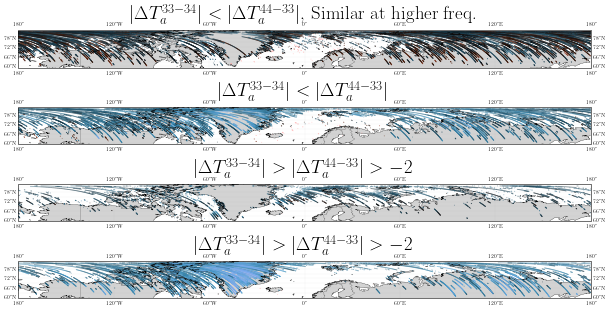

In [64]:
fig, axes = plt.subplots(4, 1,
    figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax in axes:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
    
filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_belowdiagonal_idxs, winter_idx, assume_unique=True),
    similar_at_higher_freq_idxs,
    assume_unique=True,
)

axes[0].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[0].set_title(r"$|\Delta T_{a}^{33-34}| < |\Delta T_{a}^{44-33}|$, Similar at higher freq.")

filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_belowdiagonal_idxs, winter_idx, assume_unique=True),
    different_at_higher_freq_idxs,
    assume_unique=True,
)


axes[1].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[1].set_title(r"$|\Delta T_{a}^{33-34}| < |\Delta T_{a}^{44-33}|$")

filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_abovediagonal_idxs, winter_idx, assume_unique=True),
    similar_at_higher_freq_idxs,
    assume_unique=True,
)


axes[2].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[2].set_title(r"$|\Delta T_{a}^{33-34}| > |\Delta T_{a}^{44-33}| > -2$")

fig.subplots_adjust(
    hspace=0.35,
    right=0.92,
    top=0.95,
    bottom=0.05
)

filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_abovediagonal_idxs, winter_idx, assume_unique=True),
    different_at_higher_freq_idxs,
    assume_unique=True,
)

axes[3].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[3].set_title(r"$|\Delta T_{a}^{33-34}| > |\Delta T_{a}^{44-33}| > -2$")

fig.subplots_adjust(
    hspace=0.35,
    right=0.92,
    top=0.95,
    bottom=0.05
)


plt.savefig(
        f"figures/dTa_neighbouring_channels/arctic/maps/dTa_quadrant_3_by_TCWV_andhigher_freq.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
)


In [81]:
# looking at just group 3

months = aws_db.CloudSat_Datetime.values.astype("datetime64[M]").astype(int) % 12 + 1
winter_idx = np.where(np.isin(months, [12, 1, 2]))[0]

aws34 = aws_db[f'Ta_Allsky_AWS34'].values
aws33 = aws_db[f'Ta_Allsky_AWS33'].values
aws35 = aws_db[f'Ta_Allsky_AWS35'].values
aws36 = aws_db[f'Ta_Allsky_AWS36'].values

group3_diff = aws33-aws34
group3_diff_higher_freq = aws35-aws36



# defining quadrants as starting top left, going clockwise

# quadrant 1: positive, both
group3_quadrant1_idxs = np.where(
    ((group3_diff) > 0)
    & ((group3_diff_higher_freq) > 0)
)[0]

# quadrant 3: positive group 3, negative group 4
group3_quadrant2_idxs = np.where(
    ((group3_diff) > 0)
    & ((group3_diff_higher_freq) < 0)
)[0]

# quadrant 3: negative, both
group3_quadrant3_idxs = np.where(
    ((group3_diff) < 0)
    & ((group3_diff_higher_freq) < 0)
)[0]

# quadrant 4: positive group 4, negative group 3
group3_quadrant4_idxs = np.where(
    ((group3_diff) < 0)
    & ((group3_diff_higher_freq) > 0)
)[0]


# quadrant 3 & above 1:1 (possible surface impact)
group3_quadrant3_abovediagonal_idxs = np.where(
    ((group3_diff) < 0)
    & ((group3_diff_higher_freq) < 0)
    & (np.abs(group3_diff_higher_freq) < np.abs(group3_diff))
)[0]

group3_quadrant3_belowdiagonal_idxs = np.where(
    ((group3_diff) < 0)
    & ((group3_diff_higher_freq) < 0)
    & (np.abs(group3_diff_higher_freq) > np.abs(group3_diff))
)[0]


group3_quadrant_idx_list = [group3_quadrant1_idxs, group3_quadrant2_idxs, group3_quadrant3_idxs, group3_quadrant4_idxs]

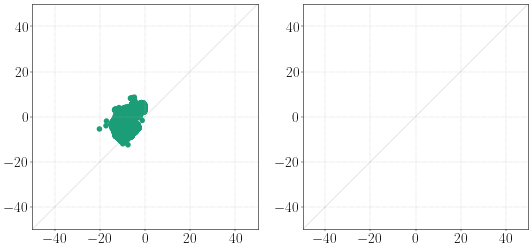

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.scatter(group3_diff[quadrant3_abovediagonal_idxs], group3_diff_higher_freq[quadrant3_abovediagonal_idxs])

for i, quadrant_idx in enumerate(group3_quadrant_idx_list):

    filter_idx = np.intersect1d(quadrant_idx, quadrant_idx_list[i], assume_unique=True)

    ax.scatter(group3_diff[filter_idx], group3_diff_higher_freq[filter_idx])

for ax in [ax1, ax2]:
    ax.plot([-50, 50], [-50, 50], color='lightgrey', lw=1, zorder=0)
    ax.grid(ls=':')
        
    ax.set_xlim([-50, 50])
    ax.set_ylim([-50, 50])
    ax.set_aspect('equal', adjustable='box')

# in both cases: want negative
# in cloudy cases: expect |higher freq (35-36)| > |lower freq (33-34)|
# in surface cases: higher freq < lower freq
# so for surface we want: quadrant 3, above 1:1 (again)

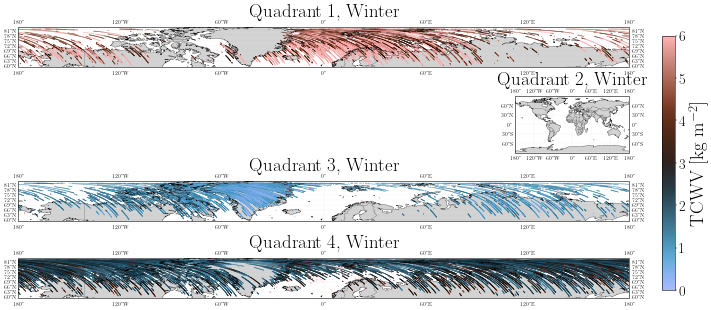

In [67]:
dry = aws_db.H2O_Column < 3

fig, axes = plt.subplots(
    4, 1,
    figsize=(20, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax in axes:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2,
                 color="gray", alpha=0.5, linestyle="--")

sc = None  # will store the last scatter

for i, quadrant_idx in enumerate(group3_quadrant_idx_list):

    filter_idx = np.intersect1d(quadrant_idx, winter_idx, assume_unique=True)

    sc = axes[i].scatter(
        aws_db["Longitude"].values[filter_idx],
        aws_db["Latitude"].values[filter_idx],
        c=aws_db.H2O_Column[filter_idx],
        cmap=cmcr.berlin,
        vmin=0,
        vmax=6,
        s=2,
        alpha=0.9,
        transform=ccrs.PlateCarree(),
    )

    axes[i].set_title(f"Quadrant {i+1}, Winter")


fig.subplots_adjust(
    hspace=0.35,   # increase until titles stop overlapping
    right=0.92,    # leaves space for the colorbar (tweak with your x=0.93)
    top=0.95,      # a bit more headroom
    bottom=0.05
)

cbar = fig.colorbar(
    sc,
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.02,
)
cbar.set_label(r"TCWV [kg m$^{-2}$]")

# move colorbar slightly left (or right)
pos = cbar.ax.get_position()
cbar.ax.set_position([0.93, pos.y0, pos.width, pos.height])

plt.savefig(
        f"figures/dTa_neighbouring_channels/arctic/maps/group3_dTa_quadrants_by_TCWV.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
)

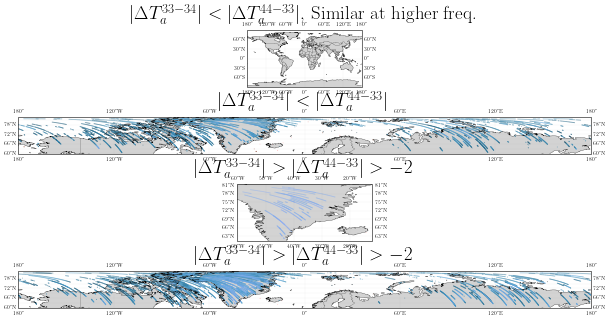

In [83]:
fig, axes = plt.subplots(4, 1,
    figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax in axes:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
    
filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_belowdiagonal_idxs, winter_idx, assume_unique=True),
    group3_quadrant3_belowdiagonal_idxs,
    assume_unique=True,
)

axes[0].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[0].set_title(r"$|\Delta T_{a}^{33-34}| < |\Delta T_{a}^{44-33}|$, Similar at higher freq.")

filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_belowdiagonal_idxs, winter_idx, assume_unique=True),
    group3_quadrant3_abovediagonal_idxs,
    assume_unique=True,
)


axes[1].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[1].set_title(r"$|\Delta T_{a}^{33-34}| < |\Delta T_{a}^{44-33}|$")

filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_abovediagonal_idxs, winter_idx, assume_unique=True),
    group3_quadrant3_belowdiagonal_idxs ,
    assume_unique=True,
)


axes[2].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[2].set_title(r"$|\Delta T_{a}^{33-34}| > |\Delta T_{a}^{44-33}| > -2$")

fig.subplots_adjust(
    hspace=0.35,
    right=0.92,
    top=0.95,
    bottom=0.05
)

filter_idx = np.intersect1d(
    np.intersect1d(quadrant3_abovediagonal_idxs, winter_idx, assume_unique=True),
    group3_quadrant3_abovediagonal_idxs,
    assume_unique=True,
)

axes[3].scatter(
    aws_db["Longitude"].values[filter_idx],
    aws_db["Latitude"].values[filter_idx],
    c=aws_db.H2O_Column[filter_idx],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[3].set_title(r"$|\Delta T_{a}^{33-34}| > |\Delta T_{a}^{44-33}| > -2$")

fig.subplots_adjust(
    hspace=0.35,
    right=0.92,
    top=0.95,
    bottom=0.05
)


plt.savefig(
        f"figures/dTa_neighbouring_channels/arctic/maps/dTa_quadrant_3_by_TCWV_and_othergroup3.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
)


Text(0.5, 1.0, '$|\\Delta T_{a}^{33-34}| < |\\Delta T_{a}^{44-33}|$, Similar at higher freq.')

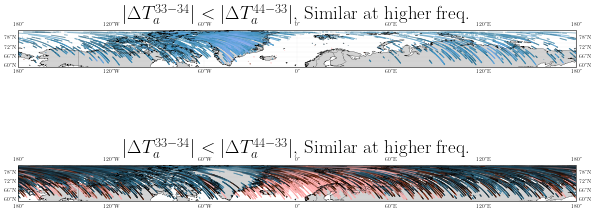

In [94]:
# just to check both quadrant 3's

quadrant_idx = np.intersect1d(
    quadrant3_idxs,
    group3_quadrant3_idxs,
    assume_unique=True,
)

winter_with_quadrant = np.intersect1d(
    winter_idx,
    quadrant_idx,
    assume_unique=True,
)

winter_without_quadrant = np.setdiff1d(
    winter_idx,
    quadrant_idx,
    assume_unique=True,
)


fig, axes = plt.subplots(2, 1,
    figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax in axes:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')


axes[0].scatter(
    aws_db["Longitude"].values[winter_with_quadrant],
    aws_db["Latitude"].values[winter_with_quadrant],
    c=aws_db.H2O_Column[winter_with_quadrant],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[0].set_title(r"$|\Delta T_{a}^{33-34}| < |\Delta T_{a}^{44-33}|$, Similar at higher freq.")


axes[1].scatter(
    aws_db["Longitude"].values[winter_without_quadrant],
    aws_db["Latitude"].values[winter_without_quadrant],
    c=aws_db.H2O_Column[winter_without_quadrant],
    cmap=cmcr.berlin,
    vmin=0,
    vmax=6,
    s=3,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)
axes[1].set_title(r"$|\Delta T_{a}^{33-34}| < |\Delta T_{a}^{44-33}|$, Similar at higher freq.")

